<a href="https://colab.research.google.com/github/AliHamzah83/NLP-Tasks/blob/main/Arabic_Text_Classification_based_on_Fine_tuning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [2]:
import pandas as pd
#pd.options.display.max_rows = 20000
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from termcolor import colored
import gensim 
import nltk
import re , string #emoji, Stemmer, functools, operator
#import re , emoji, Stemmer, functools, operator, string
import os
import re
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import csv

In [3]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [4]:
#loading Traning Data
DATA_PATH = "/content/sample_data/ar_reviews100k.tsv"
df = pd.read_csv(DATA_PATH, sep='\t')
df

,label,text
0,Positive,ممتاز. قرب الفندق من المسجد النبوي كبر مساحة ا...
1,Positive,لو ينفع اديلها اكتر من نجوم كنت اديتلها بجدروا...
2,Positive,جيد. . الإفطار في رمضان لم يكن منظم والأكل ليس...
3,Positive,إرتفع إيكاروس و إرتفع حتي إرتفع إرتفاعا شاقا، ...
4,Positive,فندق ممتاز . الموقع والخدمات وكل شيء. لاشيء
...,...,...
96525,Negative,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
96526,Negative,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
96527,Negative,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
96528,Negative,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


<Axes: xlabel='label', ylabel='count'>

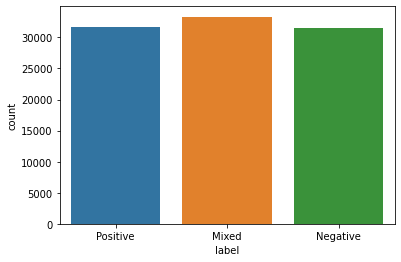

In [5]:
# Romove Mixed label according goal project
import seaborn as sns
sns.countplot(x='label', data=df)

In [6]:
df=df[df['label']!='Mixed']

In [ ]:
label_mapping = {"Positive": 1, "Negative":0}
df["label"]= df["label"].map(label_mapping)

In [ ]:
df.label

0        1
1        1
2        1
3        1
4        1
        ..
96525    0
96526    0
96527    0
96528    0
96529    0
Name: label, Length: 63197, dtype: int64

In [8]:
# Define X,y parameters
X = df.text.values
y = df.label.values

In [9]:
# The train val split is used by the DL approach but not classical ML (e.g. split traning data set into train and validation)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1, random_state=2020)

In [10]:
# Load testset
DATA_PATH = "/content/sample_data/ar_reviews100ktest.tsv"
test = pd.read_csv(DATA_PATH, sep='\t')
#test =test(['id','text'],inplace=True, plt.axis=1)

In [ ]:
test.head()

In [ ]:
import seaborn as sns
sns.countplot(x='label', data=test)

In [ ]:
# we used tow labels in test data so, we dont need to remove any more
#test =test[test['label']!='Mixed']

In [13]:
#define X,y for testset
X_test = test.text.values
y_test = test.label.values

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1,random_state=4)

In [14]:
#Loading AutoTokenizer, Automodel
from transformers import AutoTokenizer, AutoModel

In [ ]:
# using fine tuning I chose to use the Arabic-BERT model By Ali Safaya.
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic")

In [ ]:
#The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?..)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp; ..', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [16]:
# Define preprocessing util function
def Text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
  

    # Normalize unicode encoding
    #text = unicodedata.normalize('NFC', text)
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    #Remove URLs
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '<URL>', text)


    return text

In [17]:
print("the orignal is ",X[2])
print("the procees is ",Text_preprocessing(X[2]))

the orignal is  جيد. . الإفطار في رمضان لم يكن منظم والأكل ليس بمستوى جيد
the procees is  جيد. . الإفطار في رمضان لم يكن منظم والأكل ليس بمستوى جيد


In [24]:
#BERT Tokenizer
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=Text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [25]:
# Print sentence 0
print('Original: ', X[2])
print('Processed: ', preprocessing_for_bert(X[2]))

Original:  جيد. . الإفطار في رمضان لم يكن منظم والأكل ليس بمستوى جيد


NameError: ignored

In [21]:
# Concatenate train data and test data
all_tweets = np.concatenate([df.text.values, test.text.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  2665


Before tokenizing, we need to specify the maximum length of our sentences.

Now let's tokenize our data.

In [26]:
#Before tokenizing, we need to specify the maximum length of our sentences.
# Specify `MAX_LEN`
MAX_LEN =  512
# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  ممتاز. قرب الفندق من المسجد النبوي كبر مساحة الغرف توفر المصاعد بكثرة الهدوء خدمة الغرف سريعة جداالعاملون بشكل عام ودودين وخدومين. الغرف أثاثها قديم عدم وجود نوافذ للتهوية مكان الأفطار حيل ضيق مستوي الأفطار متوسطعدم وجود واي فاي في الغرف
Token IDs:  [2, 11774, 18, 6010, 8068, 1726, 5430, 7473, 18076, 7373, 11064, 5732, 2200, 2458, 18892, 18196, 3375, 11064, 10701, 2791, 8342, 2176, 1733, 2498, 2091, 22098, 1724, 2555, 14366, 7199, 18, 11064, 4171, 1731, 10658, 2917, 3053, 29969, 25573, 1993, 3108, 12583, 3616, 1008, 16087, 16676, 12583, 4017, 27482, 3053, 3541, 7361, 1725, 11064, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
#Create PyTorch DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [28]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, version="mini"):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in = 256 if version == "mini" else 768
        H, D_out = 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoModel.from_pretrained("asafaya/bert-base-arabic")
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 51.3 ms, sys: 970 µs, total: 52.3 ms
Wall time: 54.4 ms


To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

Batch size: 16 or 32
Learning rate (Adam): 5e-5, 3e-5 or 2e-5
Number of epochs: 2, 3, 4

In [29]:
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.optim import SparseAdam, Adam
def initialize_model(epochs=4, version="mini"):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False, version=version)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(params=list(bert_classifier.parameters()),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Train Model and Evaluation Function

In [30]:
import random
import time
import torch
import torch.nn as nn
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, start training our BertClassifier!

In [32]:
set_seed(3) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at asafaya/bert-mini-arabic were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.716620   |     -      |     -     |   2.14   
   1    |   40    |   0.657911   |     -      |     -     |   2.01   
   1    |   60    |   0.651455   |     -      |     -     |   2.36   
   1    |   80    |   0.608588   |     -      |     -     |   1.91   
   1    |   100   |   0.577414   |     -      |     -     |   1.88   
   1    |   120   |   0.558872   |     -      |     -     |   1.89   
   1    |   140   |   0.545379   |     -      |     -     |   1.89   
   1    |   160   |   0.507228   |     -      |     -     |   1.89   
   1    |   180   |   0.498499   |     -      |     -     |   1.92   
   1    |   200   |   0.497205   |     -      |     -     |   1.96   
   1    |   220   |   0.449176   |     -      |     -     |   1.93   
   1    |   240   |   0.509706   |     -      |     -     |   1.93   


In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
def evaluate_roc(probs, y_true, model_name, dataset_name, test_dataset_name):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title(f" ROC of {model_name}  trained on {dataset_name} dataset & evaluated on the {test_dataset_name} dataset ")
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [ ]:
# Compute predicted probabilities on the validation set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val, "BERT-mini", "arabic-sentiment-twitter-corpus", "arabic-sentiment-twitter-corpus validation")

NameError: ignored